In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Challenge/data/cleaned_train.csv')
df_test = pd.read_csv('/content/drive/My Drive/Challenge/data/cleaned_test.csv')

df.text = df.text.astype(str)
df_test.text = df_test.text.astype(str)
df.head(2)

Mounted at /content/drive


,text,domain,label
0,συμπληρωστε ερωτηματολογιο αξιοπιστια αυτοκινη...,autocarnet.gr,0
1,νικολεττα ραλλη μας μεταφερει εμπειριες φωτογρ...,queen.gr,5


In [2]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df, test_size=0.05, random_state=42)

print("Training DataFrame:")
print(df_train.shape)
print("\nValidation DataFrame:")
print(df_valid.shape)

Training DataFrame:
(1721, 3)

Validation DataFrame:
(91, 3)


GRAPH

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pickle
from tqdm import tqdm
!pip install -q torch_geometric
from torch_geometric.utils.convert import from_networkx

%cd /content/drive/My Drive/Challenge/

# Load the graph from pickle file
G = pickle.load(open('graph.pickle', 'rb'))

# Extract node names and labels from the DataFrame
train_nodes = df_train['domain'].tolist()
train_labels = df_train['label'].tolist()

val_nodes = df_valid['domain'].tolist()
val_labels = df_valid['label'].tolist()

test_nodes = df_test['domain'].tolist()
# Create dictionaries for node labels, real index, and masks
node_label_train = dict(zip(train_nodes, train_labels))
node_label_val = dict(zip(val_nodes, val_labels))
node_label_test = test_nodes

# Update node attributes in the graph
for node in G.nodes():
    if node in node_label_train:
        G.nodes[node]['label'] = node_label_train[node]
        G.nodes[node]['train_mask'] = True
        G.nodes[node]['val_mask'] = False
        G.nodes[node]['test_mask'] = False
    elif node in node_label_val:
        G.nodes[node]['label'] = node_label_val[node]
        G.nodes[node]['train_mask'] = False
        G.nodes[node]['val_mask'] = True
        G.nodes[node]['test_mask'] = False
    elif node in node_label_test:
        G.nodes[node]['label'] = False
        G.nodes[node]['train_mask'] = False
        G.nodes[node]['val_mask'] = False
        G.nodes[node]['test_mask'] = True
    else:
        # Handle nodes without labels
        G.nodes[node]['label'] = False
        G.nodes[node]['train_mask'] = False
        G.nodes[node]['val_mask'] = False
        G.nodes[node]['test_mask'] = False
    G.nodes[node]['name'] = node

# Convert NetworkX graph to PyTorch Geometric data object
data = from_networkx(G)

# Load the Data object, in order to update the features
data2 = torch.load('data_128.pt')

# Update the features in the data object
data.x = data2.x
data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.1 MB/s eta 0:00:00
/content/drive/My Drive/Challenge


Data(edge_index=[2, 1642073], label=[65208], train_mask=[65208], val_mask=[65208], test_mask=[65208], name=[65208], num_nodes=65208, x=[65208, 128])

In [5]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import BatchNorm1d, LeakyReLU, Dropout


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)

        self.conv1 = GCNConv(128 , 128,bias=False)
        self.conv2 = GCNConv(128, 128,bias=False)

        self.dropout = torch.nn.Dropout(0.5)
        self.bn1 = BatchNorm1d(128)

        self.skip_linear1 = Linear(128, 128,bias=False)


        self.classifier = Linear(128, 9)

    def forward(self, x, edge_index):
        # Initial embedding
        h_0 = x

        # First GCN layer
        h = self.conv1(x, edge_index)
        h_1 = self.dropout(h)

        # Apply skip connection from initial embedding
        h = h_1 +self.skip_linear1(self.dropout(h_0))
        h = torch.tanh(h)

        # Second GCN layer
        h = self.conv2(h, edge_index)
        h_2 = self.dropout(h)

        # Apply skip connection from initial embedding
        h = h_2 + self.skip_linear1(self.dropout(h_1))
        h = torch.tanh(h)

        # Final GNN embedding space
        out = self.classifier(h)

        return out, h

gcn_model = GCN()
print(gcn_model)

GCN(
  (conv1): GCNConv(128, 128)
  (conv2): GCNConv(128, 128)
  (dropout): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (skip_linear1): Linear(in_features=128, out_features=128, bias=False)
  (classifier): Linear(in_features=128, out_features=9, bias=True)
)


In [6]:
# TRAIN
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = torch.nn.CrossEntropyLoss()  #Initialize the CrossEntropyLoss function.
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01) # Initialize the Adam optimizer.
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_val_loss = float('inf')
def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = gcn_model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.label[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    return loss, h

def valid(data):
    gcn_model.eval()  # Set model to evaluation mode.
    with torch.no_grad():
        out, h = gcn_model(data.x, data.edge_index)  # Perform a forward pass.
        loss = criterion(out[data.val_mask], data.label[data.val_mask])  # Compute the loss solely based on the validation nodes.
    return loss, h

for epoch in range(40):
    lr = scheduler.get_last_lr()
    loss, h = train(data)
    val_loss, h = valid(data)
    scheduler.step(val_loss)
    if scheduler.get_last_lr() != lr:
      print(scheduler.get_last_lr())
    print(f'Epoch: {epoch}, Loss: {loss} | val_loss {val_loss.item()}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        #Save the model weights.
        torch.save(gcn_model.state_dict(), 'best_gcn_weights.pth')

Epoch: 0, Loss: 2.155385732650757 | val_loss 2.0704731941223145
Epoch: 1, Loss: 2.2181448936462402 | val_loss 2.119241714477539
Epoch: 2, Loss: 2.036741018295288 | val_loss 1.8179811239242554
Epoch: 3, Loss: 1.7962841987609863 | val_loss 1.5014387369155884
Epoch: 4, Loss: 1.5856881141662598 | val_loss 1.3907510042190552
Epoch: 5, Loss: 1.5144199132919312 | val_loss 1.3123211860656738
Epoch: 6, Loss: 1.4084662199020386 | val_loss 1.2643461227416992
Epoch: 7, Loss: 1.3062000274658203 | val_loss 1.198736548423767
Epoch: 8, Loss: 1.2317501306533813 | val_loss 1.0596998929977417
Epoch: 9, Loss: 1.1425247192382812 | val_loss 0.9728931784629822
Epoch: 10, Loss: 1.09559965133667 | val_loss 0.9177325963973999
Epoch: 11, Loss: 1.0423797369003296 | val_loss 0.8878876566886902
Epoch: 12, Loss: 0.992576003074646 | val_loss 0.861966073513031
Epoch: 13, Loss: 0.9580473899841309 | val_loss 0.8167111873626709
Epoch: 14, Loss: 0.9185693860054016 | val_loss 0.7792292833328247
Epoch: 15, Loss: 0.883830010

In [7]:
# Load the saved weights.
try:
    gcn_model.load_state_dict(torch.load('best_gcn_weights.pth'))
    print("Previous model weights loaded successfully.")
except FileNotFoundError:
    print("No previous model weights found. Training from scratch.")

Previous model weights loaded successfully.


In [8]:
# PREDICTIONS
import torch.nn.functional as F

def test(data):
    gcn_model.eval()  # Set model to evaluation mode.
    with torch.no_grad():
        out, _ = gcn_model(data.x, data.edge_index)  # Perform a forward pass.
    return out[data.val_mask]

# val_preds = test(data)
# sorted_val_preds = val_preds[index.long().argsort()]

val_predictions = F.softmax(test(data), dim=1)

In [9]:
# Sort prediction in the right way
val_predictions_list = val_predictions.tolist()

val_node_names = [data.name[i] for i in range(len(data.name)) if data.val_mask[i]]

domain_predictions = dict(zip(val_node_names, val_predictions_list))

df_valid['predictions'] = df_valid['domain'].map(domain_predictions)

In [10]:
val_predictions = np.array(df_valid.predictions)
val_predictions = np.array(val_predictions.tolist())

In [11]:
# cross-entropy loss for multi-class classification
def multiclass_cross_entropy(y_true, y_pred_prob):
    epsilon = 1e-15  # small value to prevent log(0)
    # clip predicted probabilities to avoid log(0)
    y_pred_prob = np.clip(y_pred_prob, epsilon, 1 - epsilon)
    # compute cross-entropy loss
    loss = -np.mean(np.sum(y_true * np.log(y_pred_prob), axis=1))
    return loss

# Convert categorical variable into dummy/indicator variables (one-hot encoding)
one_hot_yval = pd.get_dummies(df_valid.label)
one_hot_yval = one_hot_yval.astype(int)
one_hot_yval = one_hot_yval.values

print(one_hot_yval.shape)

(91, 9)


In [12]:
multiclass_cross_entropy(one_hot_yval,val_predictions)

0.5852535917474895

In [13]:
import numpy as np

# Assuming one_hot_yval and val_predictions are numpy arrays

# Convert one_hot_yval to class labels
y_true = np.argmax(one_hot_yval, axis=1)

# Convert val_predictions to class labels
y_pred = np.argmax(val_predictions, axis=1)

# Calculate accuracy
accuracy = np.mean(y_true == y_pred) * 100

print("Accuracy:", accuracy, "%")

Accuracy: 80.21978021978022 %


BERT

In [ ]:
df_all = pd.read_csv('/content/drive/My Drive/Challenge/data/cleaned_all.csv')
preds_all = pd.read_csv('/content/drive/My Drive/Challenge/data/all_preds_from_gcn_099.csv')
df_all.text = df_all.text.astype(str)

merged_df = df_all.merge(preds_all, left_on='domain', right_on='node_name', how='inner')
merged_df = merged_df[['domain','text','class']]
merged_df = merged_df.rename(columns={'class':'label'})
merged_df.head()

# df_train = pd.concat([df_train,merged_df])
# df_train.text = df_train.text.astype(str)
# df_train.shape

,domain,text,label
0,3on3kingofthecourt-sbt.blogspot.gr,ημερα ανοιξαν εγγραφες συνολικα ομαδες προλαβα...,1
1,3x3basketball.blogspot.gr,κυριακη απριλιου αρης παραδεισας νουμερο ενα α...,1
2,5glamclub.blogspot.gr,πριν αρκετο καιρο μαριαννα μου χαρισε δυο πιο ...,8
3,5x5hellas.gr,ειδησεις πεπσς ανακοινωνει διενεργεια σχολης δ...,1
4,7media.gr,φωτογραφιση μυστηριου εκκλησια εναν φωτογραφο ...,5


In [ ]:
exploded = df_train
exploded['text'] = df_train['text'].str.split(r'\* # \*')
# Explode the DataFrame
exploded = exploded.explode('text')
exploded.reset_index(inplace=True)
exploded = exploded.rename(columns={'index':'real_index'})
exploded.head()

,real_index,text,domain,label,token_count
0,1263,σαββατο αυγουστου εχει περασει αρκετος καιρος ...,trikaladay.gr,3,10927
1,1263,τεταρτη μαιου αισθανομαι πολυ τυχερος διοτι π...,trikaladay.gr,3,10927
2,1263,σαββατο ιουλιου δευτερος χρονος οπου εθνικη ε...,trikaladay.gr,3,10927
3,1263,τριτη ιανουαριου ευρωλιγκα γυναικων μια πολυ ...,trikaladay.gr,3,10927
4,1263,παρασκευη ιουνιου προβληματα πολλα πραγματα α...,trikaladay.gr,3,10927


In [ ]:
exploded = df_valid
exploded['text'] = df_valid['text'].str.split(r'\* # \*')
# Explode the DataFrame
exploded = exploded.explode('text')
# exploded.reset_index(inplace=True)
exploded = exploded.rename(columns={'index':'real_index'})
exploded.head()

,level_0,real_index,text,domain,label,predictions,token_count
0,0,1605,NaN,alphafm.gr,3,"[0.00035497755743563175, 0.0002714179863687604...",7590
1,1,707,NaN,mommyjammi.gr,6,"[0.00011211060336790979, 0.0002841267269104719...",1
2,2,1791,NaN,anagenisi-karditsas.gr,1,"[0.0003164488298352808, 0.9886019825935364, 0....",8062
3,3,1631,NaN,laptop-parts.gr,5,"[0.03619622066617012, 0.13499948382377625, 0.0...",896
4,4,916,NaN,larisanew.gr,3,"[0.004591342993080616, 0.014725451357662678, 0...",2073


In [ ]:
df_train = exploded

In [14]:
import re

train_clean = []
for sent in df_train.text:

  sent = sent.replace('* # *',' ')

  train_clean.append(sent)

df_train.text = train_clean

val_clean = []
for sent in df_valid.text:

  sent = sent.replace('* # *','')

  val_clean.append(sent)

df_valid.text = val_clean

In [15]:
def count_tokens(text):
    tokens = text.split()
    return len(tokens)

df_train['token_count'] = df_train['text'].apply(count_tokens)
df_valid['token_count'] = df_valid['text'].apply(count_tokens)

In [16]:
df_train[df_train.token_count < 10]

,text,domain,label,token_count
1674,nan,sportfeeds.gr,1,1
1157,nan,sciencenews.gr,5,1
712,nan,andreasmorakis.gr,8,1
607,nan,wingchun-online.gr,1,1
859,nan,prevezaposto.gr,3,1
...,...,...,...,...
1482,nan,inpaok.gr,1,1
330,nan,domains24.gr,5,1
1044,nan,imerazante.gr,3,1
860,nan,impression-estudio.gr,5,1


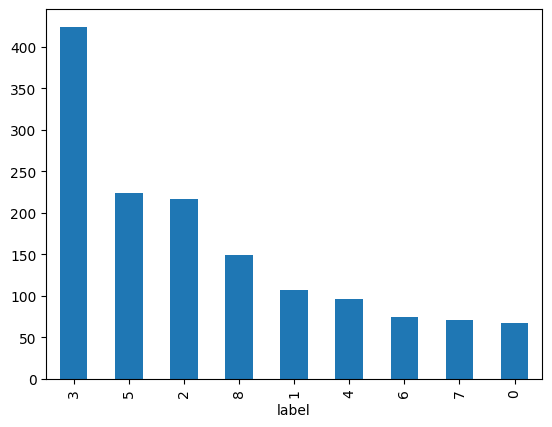

In [17]:
df_train = df_train[df_train.token_count > 10]
df_train.label.value_counts().plot.bar();

In [18]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [19]:
#Reproducing same results
SEED = 1311

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True

In [20]:
# Hyperparameters
MAX_LEN = 300
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-05

In [21]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
model = AutoModel.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

In [22]:
# Function for the tokenization
def tokenize_text(data, tokenizer, max_length=MAX_LEN):
    return tokenizer(list(data), padding='max_length', max_length=max_length, truncation=True, return_tensors='pt')

bert_train = tokenize_text(df_train.text, tokenizer)
bert_val = tokenize_text(df_valid.text, tokenizer)
# bert_test = tokenize_text(exploded_test.text, tokenizer)

# bert_test['input_ids'].shape

In [23]:
class BertClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = model
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        outputs = self.dropout(outputs)
        logits = self.classifier(outputs)
        return logits

model_1 = BertClassifier(num_classes=9)

In [24]:
# Assuming df_train is your DataFrame
class_counts = df_train.label.value_counts()
total_samples = class_counts.sum()

class_distribution = 1 - class_counts / total_samples
class_distribution_sorted = class_distribution.sort_index()

print(class_distribution_sorted)

label
0    0.953147
1    0.925175
2    0.848252
3    0.703497
4    0.932867
5    0.843357
6    0.947552
7    0.950350
8    0.895804
Name: count, dtype: float64


In [25]:
class_weights = class_distribution_sorted.values

class_weights_tensor = torch.FloatTensor(class_weights)
class_weights_tensor = class_weights_tensor.to(device)

In [26]:
# Create loss function
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.AdamW(model_1.parameters(), lr=LEARNING_RATE)
criterion2 = nn.CrossEntropyLoss()


In [27]:
model_1.to(device)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

train_inputs = bert_train['input_ids'].to(device)
train_masks = bert_train['attention_mask'].to(device)
train_labels = torch.tensor(df_train.label.values, dtype=torch.long).to(device)

val_inputs = bert_val['input_ids'].to(device)
val_masks = bert_val['attention_mask'].to(device)
val_labels = torch.tensor(df_valid.label.values, dtype=torch.long).to(device)

# Create Tensor datasets
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)

min_val_loss = 20
best_model_weights = model_1.state_dict().copy()

EPOCHS = 10
accumulation_steps = 2

# Training loop
for epoch in range(EPOCHS):
    model_1.train()
    total_loss = 0
    optimizer.zero_grad()
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # Forward pass
        logits = model_1(input_ids, attention_mask)

        loss = criterion(logits, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        if (batch_idx + 1) % accumulation_steps == 0:
            # Update weights after accumulation_steps batches
            optimizer.step()
            optimizer.zero_grad()  # Zero the gradients for the next accumulation


    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}")

    # Validation loop
    model_1.eval()
    val_loss = 0
    correct = 0
    total = 0
    softmax_loss = 0
    with torch.inference_mode():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            # Forward pass
            logits = model_1(input_ids, attention_mask)

            # Calculate loss
            loss = criterion2(logits, labels)

            # Get the predicted class
            _, predicted = torch.max(logits, 1)

            val_loss += loss.item()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    avg_softmax_loss = softmax_loss / len(val_loader)

    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        best_model_weights = model_1.state_dict()
        print("Validation loss improved. Saving the model.")

    print(f"Epoch {epoch+1}/{EPOCHS}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


100%|██████████| 90/90 [00:30<00:00,  2.95it/s]


Epoch 1/10, Train Loss: 2.0455
Validation loss improved. Saving the model.
Epoch 1/10, Validation Loss: 1.6757, Validation Accuracy: 0.4396


100%|██████████| 90/90 [00:29<00:00,  3.00it/s]


Epoch 2/10, Train Loss: 1.6198
Validation loss improved. Saving the model.
Epoch 2/10, Validation Loss: 1.3586, Validation Accuracy: 0.5824


100%|██████████| 90/90 [00:30<00:00,  2.97it/s]


Epoch 3/10, Train Loss: 1.2487
Validation loss improved. Saving the model.
Epoch 3/10, Validation Loss: 1.1786, Validation Accuracy: 0.6374


100%|██████████| 90/90 [00:30<00:00,  2.92it/s]


Epoch 4/10, Train Loss: 1.0046
Validation loss improved. Saving the model.
Epoch 4/10, Validation Loss: 1.0612, Validation Accuracy: 0.6484


100%|██████████| 90/90 [00:31<00:00,  2.89it/s]


Epoch 5/10, Train Loss: 0.8282
Validation loss improved. Saving the model.
Epoch 5/10, Validation Loss: 1.0223, Validation Accuracy: 0.6703


100%|██████████| 90/90 [00:31<00:00,  2.89it/s]


Epoch 6/10, Train Loss: 0.6799
Validation loss improved. Saving the model.
Epoch 6/10, Validation Loss: 0.9910, Validation Accuracy: 0.6703


100%|██████████| 90/90 [00:31<00:00,  2.90it/s]


Epoch 7/10, Train Loss: 0.5663
Validation loss improved. Saving the model.
Epoch 7/10, Validation Loss: 0.9406, Validation Accuracy: 0.6703


100%|██████████| 90/90 [00:31<00:00,  2.90it/s]


Epoch 8/10, Train Loss: 0.4470
Epoch 8/10, Validation Loss: 0.9692, Validation Accuracy: 0.6813


100%|██████████| 90/90 [00:31<00:00,  2.89it/s]


Epoch 9/10, Train Loss: 0.3392
Epoch 9/10, Validation Loss: 0.9686, Validation Accuracy: 0.6374


100%|██████████| 90/90 [00:31<00:00,  2.89it/s]


Epoch 10/10, Train Loss: 0.2373
Epoch 10/10, Validation Loss: 0.9626, Validation Accuracy: 0.6813


In [30]:
# Load the best model weights
if best_model_weights is not None:
    model_1.load_state_dict(best_model_weights)
    print("Successfull")

# # Save the model state dictionary to a file
torch.save(model_1.state_dict(), '/content/drive/My Drive/Challenge/model_weights.pth')

Successfull


EVALUATE

In [ ]:
# k = df_valid[df_valid.token_count>1]
# bert_val = tokenize_text(df_valid.text, tokenizer)

In [31]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
# and corresponding labels in a tensor called val_labels
test_inputs = bert_val['input_ids'].to(device)
test_masks = bert_val['attention_mask'].to(device)

# Create Tensor datasets
test_dataset = TensorDataset(test_inputs, test_masks)
test_loader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE)

# Set the model to evaluation mode
model_1.eval()

predicted_labels = []
probabilities_list = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        # Forward pass
        logits = model_1(input_ids, attention_mask)

        # Apply softmax to get probabilities
        probabilities = torch.softmax(logits, dim=1)

        # Get the predicted class
        _, predicted_classes = torch.max(probabilities, 1)

        # Convert predicted class indices to actual labels and append to the list
        predicted_labels.extend(predicted_classes.tolist())

        # Append probabilities to the list
        probabilities_list.append(probabilities)

# Concatenate probabilities from all batches
probabilities = torch.cat(probabilities_list, dim=0)
probabilities = probabilities.cpu().numpy()

100%|██████████| 6/6 [00:00<00:00,  9.22it/s]


In [32]:
multiclass_cross_entropy(one_hot_yval, probabilities)

0.9559275190867893

In [33]:
import numpy as np

def calculate_accuracy(aggregated_probs, one_hot_yval):
    # Extracting the predicted labels from probabilities
    predicted_labels = np.argmax(aggregated_probs, axis=1)

    # Extracting the ground truth labels from one-hot encoding
    true_labels = np.argmax(one_hot_yval, axis=1)

    # Comparing predicted labels with true labels
    correct_predictions = np.sum(predicted_labels == true_labels)

    # Calculating accuracy
    accuracy = correct_predictions / len(true_labels)

    return accuracy
calculate_accuracy(probabilities,one_hot_yval)

0.6813186813186813

COMBINE

In [34]:
df_valid.reset_index(inplace=True)
empty_index = df_valid[(df_valid.token_count<100)].index
probabilities[empty_index] = val_predictions[empty_index]

In [35]:
preds = (probabilities+val_predictions)/2
multiclass_cross_entropy(one_hot_yval, preds)

0.5130605817231437

In [36]:
import numpy as np

def calculate_accuracy(aggregated_probs, one_hot_yval):
    # Extracting the predicted labels from probabilities
    predicted_labels = np.argmax(aggregated_probs, axis=1)

    # Extracting the ground truth labels from one-hot encoding
    true_labels = np.argmax(one_hot_yval, axis=1)

    # Comparing predicted labels with true labels
    correct_predictions = np.sum(predicted_labels == true_labels)

    # Calculating accuracy
    accuracy = correct_predictions / len(true_labels)

    return accuracy
calculate_accuracy(preds,one_hot_yval)

0.8681318681318682

TEST

,text,domain,label,token_count
1686,ηδη πανω εκατομμυρια παικτες ανα κοσμο μοναδικ...,sfgame.gr,2,45
1648,τελευταιες ειδησεις πρωτη ελληνικη ιστοσελιδα ...,vrnews.gr,5,97
1176,παρουσιαζονται προβληματα ακροαση επικοινωνηστ...,live24.gr,3,90
271,αφισες αφισες αφισες αφισες αφισες α...,veggos.gr,2,11
1699,ερθω ερμιονη καλωσηρθατε ερμιονη ερμιονη μια π...,ermionigreece.gr,7,89
...,...,...,...,...
1315,πανος ρωτας πανος ρωτας παντρεμενος πατερας πα...,why-n.gr,1,90
1322,παραμυθι μουσικης διδυμοτειχο πλεονασμα χιλιαδ...,xarama.gr,7,76
1323,υπαρχουν διαθεσιμες καταχωρησεις διαστημα χαρτ...,xartinoskosmos.gr,2,12
1324,ανταλλακτικα αυτοκινητων καλως ηλθατε συγχρονο...,xcar.gr,0,82


In [ ]:
df_valid[(df_valid.token_count<100)]

,level_0,index,text,domain,label,predictions,token_count
1,1,707,nan,mommyjammi.gr,6,"[0.00011211060336790979, 0.0002841267269104719...",1
7,7,173,nan,neolaia.org.gr,3,"[0.0016372159589082003, 0.0006352272466756403,...",1
10,10,759,nan,manbiz.gr,5,"[3.4069867979269475e-05, 0.00506838271394372, ...",1
14,14,237,nan,makemeup.gr,8,"[4.927796180709265e-05, 0.0009128111996687949,...",1
15,15,771,nan,koyinta.gr,2,"[1.5969571904861368e-05, 0.0001499732607044279...",1
17,17,1458,nan,greek-chat.gr,2,"[0.11428564041852951, 0.0438602976500988, 0.43...",1
24,24,109,nan,gateoftech.gr,5,"[0.015733560547232628, 0.002771786879748106, 0...",1
32,32,1461,nan,michanikosapps.gr,5,"[0.0014443191466853023, 3.0864561267662793e-05...",1
33,33,1582,nan,ipiros.gr,3,"[9.86519517027773e-05, 0.0014896505745127797, ...",1
34,34,1432,nan,xanthitimes.gr,3,"[0.00041653611697256565, 0.001171137555502355,...",1


In [37]:
# df_test = pd.read_csv('/content/drive/My Drive/Challenge/data/cleaned_test.csv')
df_test.text = df_test.text.astype(str)

In [38]:
# PREDICTIONS
import torch.nn.functional as F

def test(data):
    gcn_model.eval()  # Set model to evaluation mode.
    with torch.no_grad():
        out, _ = gcn_model(data.x, data.edge_index)  # Perform a forward pass.
    return out[data.test_mask]

val_predictions = F.softmax(test(data), dim=1)
# Sort prediction in the right way
val_predictions_list = val_predictions.tolist()

val_node_names = [data.name[i] for i in range(len(data.name)) if data.test_mask[i]]

domain_predictions = dict(zip(val_node_names, val_predictions_list))

df_test['predictions'] = df_test['domain'].map(domain_predictions)
val_predictions = np.array(df_test.predictions)
val_predictions = np.array(val_predictions.tolist())

In [39]:
import re

test_clean = []
for sent in df_test.text:

  sent = sent.replace('* # *',' ')

  test_clean.append(sent)

df_test.text = test_clean

In [40]:
def count_tokens(text):
    tokens = text.split()
    return len(tokens)

df_test['token_count'] = df_test['text'].apply(count_tokens)
# df_valid['token_count'] = df_valid['text'].apply(count_tokens)

In [41]:
bert_test = tokenize_text(df_test.text, tokenizer)


In [42]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
# and corresponding labels in a tensor called val_labels
test_inputs = bert_test['input_ids'].to(device)
test_masks = bert_test['attention_mask'].to(device)

# Create Tensor datasets
test_dataset = TensorDataset(test_inputs, test_masks)
test_loader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE)

# Set the model to evaluation mode
model_1.eval()

predicted_labels = []
probabilities_list = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        # Forward pass
        logits = model_1(input_ids, attention_mask)

        # Apply softmax to get probabilities
        probabilities = torch.softmax(logits, dim=1)

        # Get the predicted class
        _, predicted_classes = torch.max(probabilities, 1)

        # Convert predicted class indices to actual labels and append to the list
        predicted_labels.extend(predicted_classes.tolist())

        # Append probabilities to the list
        probabilities_list.append(probabilities)

# Concatenate probabilities from all batches
probabilities = torch.cat(probabilities_list, dim=0)
probabilities = probabilities.cpu().numpy()

100%|██████████| 38/38 [00:04<00:00,  8.35it/s]


In [43]:
df_test.reset_index(inplace=True)
empty_index = df_test[(df_test.token_count<100)].index
probabilities[empty_index] = val_predictions[empty_index]

In [44]:
empty_index

Index([  1,   4,  10,  13,  16,  20,  27,  28,  37,  40,
       ...
       521, 533, 539, 545, 547, 550, 559, 564, 597, 599],
      dtype='int64', length=109)

In [45]:
preds = (probabilities+2*val_predictions)/3


In [46]:
test_domains = pd.read_csv('test_domains.csv')
test_domains = test_domains.rename(columns={'0':'domain'})
test_domains.head()

,Unnamed: 0,domain
0,0,startupper.gr
1,1,artware.gr
2,2,oneirokritis.blogspot.gr
3,3,kali-ellada.blogspot.gr
4,4,ote.gr


In [47]:
import csv

# Write predictions to a file
with open('/content/drive/My Drive/Challenge/predictions_combine.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(9):
        lst.append('class_'+str(i))
    lst.insert(0, "domain_name")
    writer.writerow(lst)
    for i,test_host in enumerate(test_domains['domain']):
        lst = preds[i].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)